In [9]:
import numpy as np
import variational_bayes as vb
import scipy.stats
from matplotlib import pyplot as plt, rcParams
from tqdm import tqdm_notebook
%matplotlib inline
rcParams['figure.dpi'] = 144

In [10]:
# Generate some data
np.random.seed(1)
n = 50
m = 51
p = 2
missing_proba = 0.1
x = np.random.normal(0, 1, (n, p))
theta = np.random.normal(0, 1, (m, p))
predictor = np.dot(x, theta.T)
y = np.random.normal(0, 1, predictor.shape) + predictor
y_observed = y.copy()
y_observed[np.random.uniform(size=y.shape) < missing_proba] = np.nan

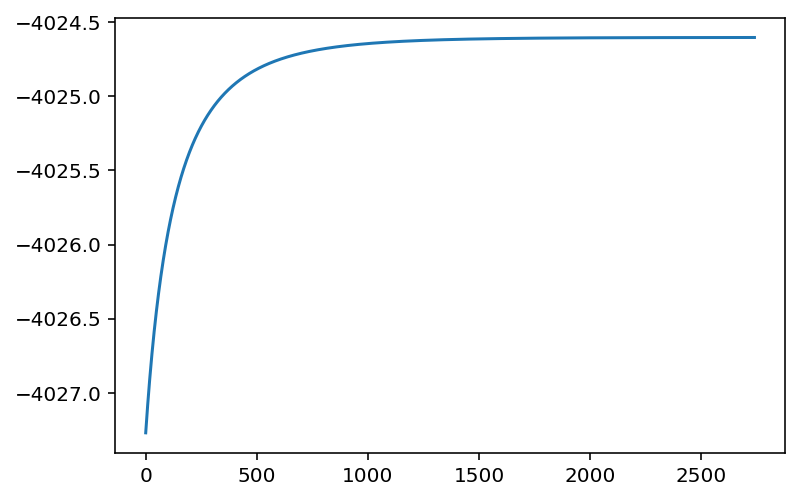

In [11]:
def collaborative_filtering_model(p):
    factors = {
        'x': vb.MultiNormalDistribution(
            np.random.normal(0, 1, (n, p)), 
            np.ones((n, p, 1)) * np.eye(p)
        ),
        'theta': vb.MultiNormalDistribution(
            np.random.normal(0, 1, (m, p)), 
            np.ones((m, p, 1)) * np.eye(p)
        ),
        'tau': vb.GammaDistribution(1, 1)
    }

    cf_dist = vb.CollaborativeFilteringDistribution(
        factors['x'], factors['theta'], factors['tau'], strict=False
    )
    likelihoods = [
        cf_dist.likelihood(y_observed),
        # Priors to regularise the inference
        vb.MultiNormalDistribution(np.zeros(p), 1e-2 * np.eye(p)).likelihood(factors['x']),
        vb.MultiNormalDistribution(np.zeros(p), 1e-2 * np.eye(p)).likelihood(factors['theta']),
        vb.GammaDistribution(1e-3, 1e-3).likelihood(factors['tau']),
    ]
    return vb.Model(factors, likelihoods)

model = collaborative_filtering_model(p)
elbos, _ = model.update(None, tqdm_notebook, convergence_predicate=1e-6)
plt.plot(elbos[10:])

Slope: 0.943847
Intercept: 0.004376


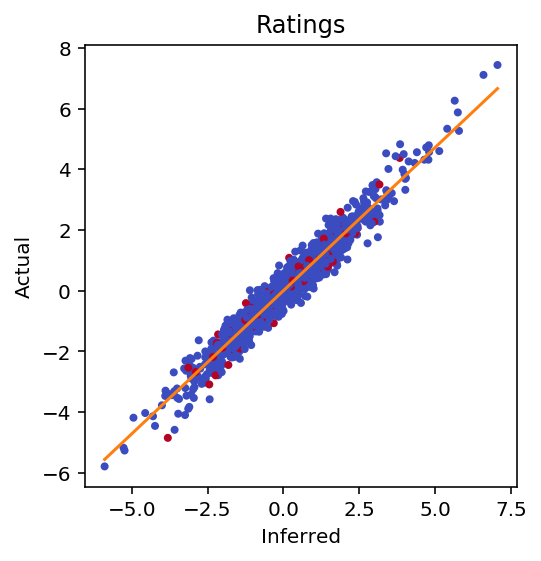

2741it [00:30, 91.31it/s]

In [12]:
fig, ax = plt.subplots(1, 1)
cf_dist = model._likelihoods[0].distribution
a = cf_dist.mean.ravel()
b = predictor.ravel()

fit = scipy.stats.linregress(a, b)
print("Slope: %f" % fit.slope)
print("Intercept: %f" % fit.intercept)

ax.scatter(a, b, marker='.', c=np.isnan(y_observed), cmap='coolwarm')
ax.set_aspect(1)
minmax = np.asarray([np.min(a), np.max(a)])
ax.plot(minmax, fit.intercept + fit.slope * minmax, color='C1')
ax.set_xlabel('Inferred')
ax.set_ylabel('Actual')
ax.set_title('Ratings')
fig.tight_layout()

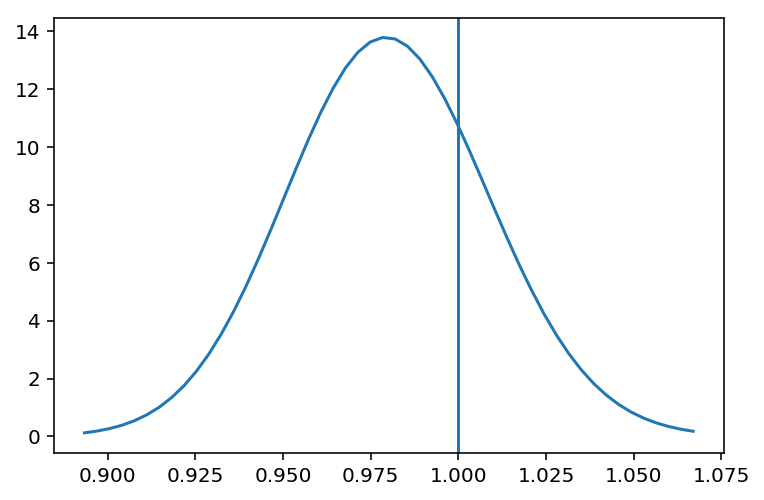

In [5]:
vb.plot_proba(model['tau'], reference=1.0)

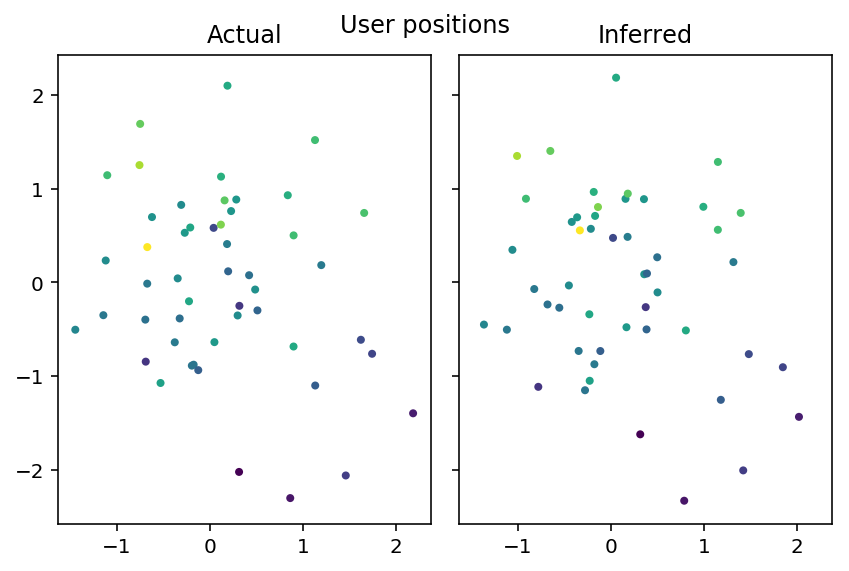

In [6]:
# Determine the transform that maps the actual positions and the
# inferred positions onto each other in the least-square sense
def func(arg):
    b = arg[:p]
    A = arg[p:].reshape(p, p)
    return (x - (b + np.dot(model['x'].mean, A))).ravel()

x0 = np.concatenate([np.zeros(p), np.eye(p).ravel()])
fit, _ = scipy.optimize.leastsq(func, x0)
b = fit[:p]
A = fit[p:].reshape(p, p)

fig, (ax1, ax2) = plt.subplots(1, 2, True, True)
kwargs = {'marker': '.'}
ax1.scatter(*x.T, c=y[:, 0], **kwargs)
ax2.scatter(*(b + np.dot(model['x'].mean, A)).T, c=y[:, 0], **kwargs)
ax1.set_title('Actual')
ax2.set_title('Inferred')
fig.suptitle('User positions')
fig.tight_layout()

In [7]:
list_num_dims = [1, 2, 3, 4]
elbos = []
for num_dims in tqdm_notebook(list_num_dims):
    ensemble = vb.ModelEnsemble(collaborative_filtering_model, (num_dims,))
    ensemble.update(10, None, tqdm_notebook, convergence_predicate=1e-3)
    elbos.append(ensemble.best_elbo)

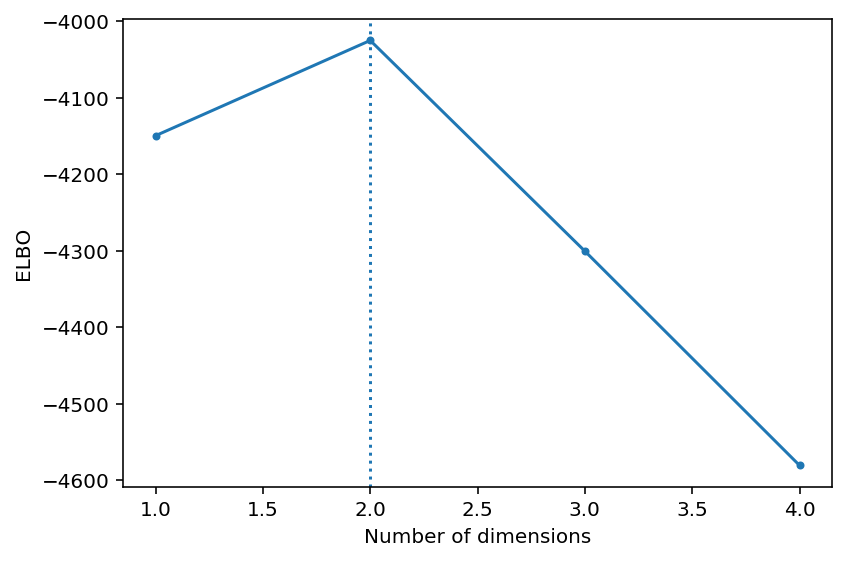

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(list_num_dims, elbos, marker='.')
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('ELBO')
ax.axvline(p, ls=':')
fig.tight_layout()